In [1]:
"""
Import the libraries
"""

# to develop the nn
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np # data manipulation
import random

In [2]:
"""
Download the Shakespeare dataset
"""

path = tf.keras.utils.get_file('shakespeare.txt',
'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
"""
Read the data
"""

# Read, then decode for py2 compat
text = open(path, 'rb').read().decode(encoding='utf-8') 

# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')  
vocab = sorted(set(text)) 
print(f'{len(vocab)} unique characters') # the unique characters in the file
print(f'All unique characters: {vocab}') # all unique characters in the file

Length of text: 1115394 characters
65 unique characters
All unique characters: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


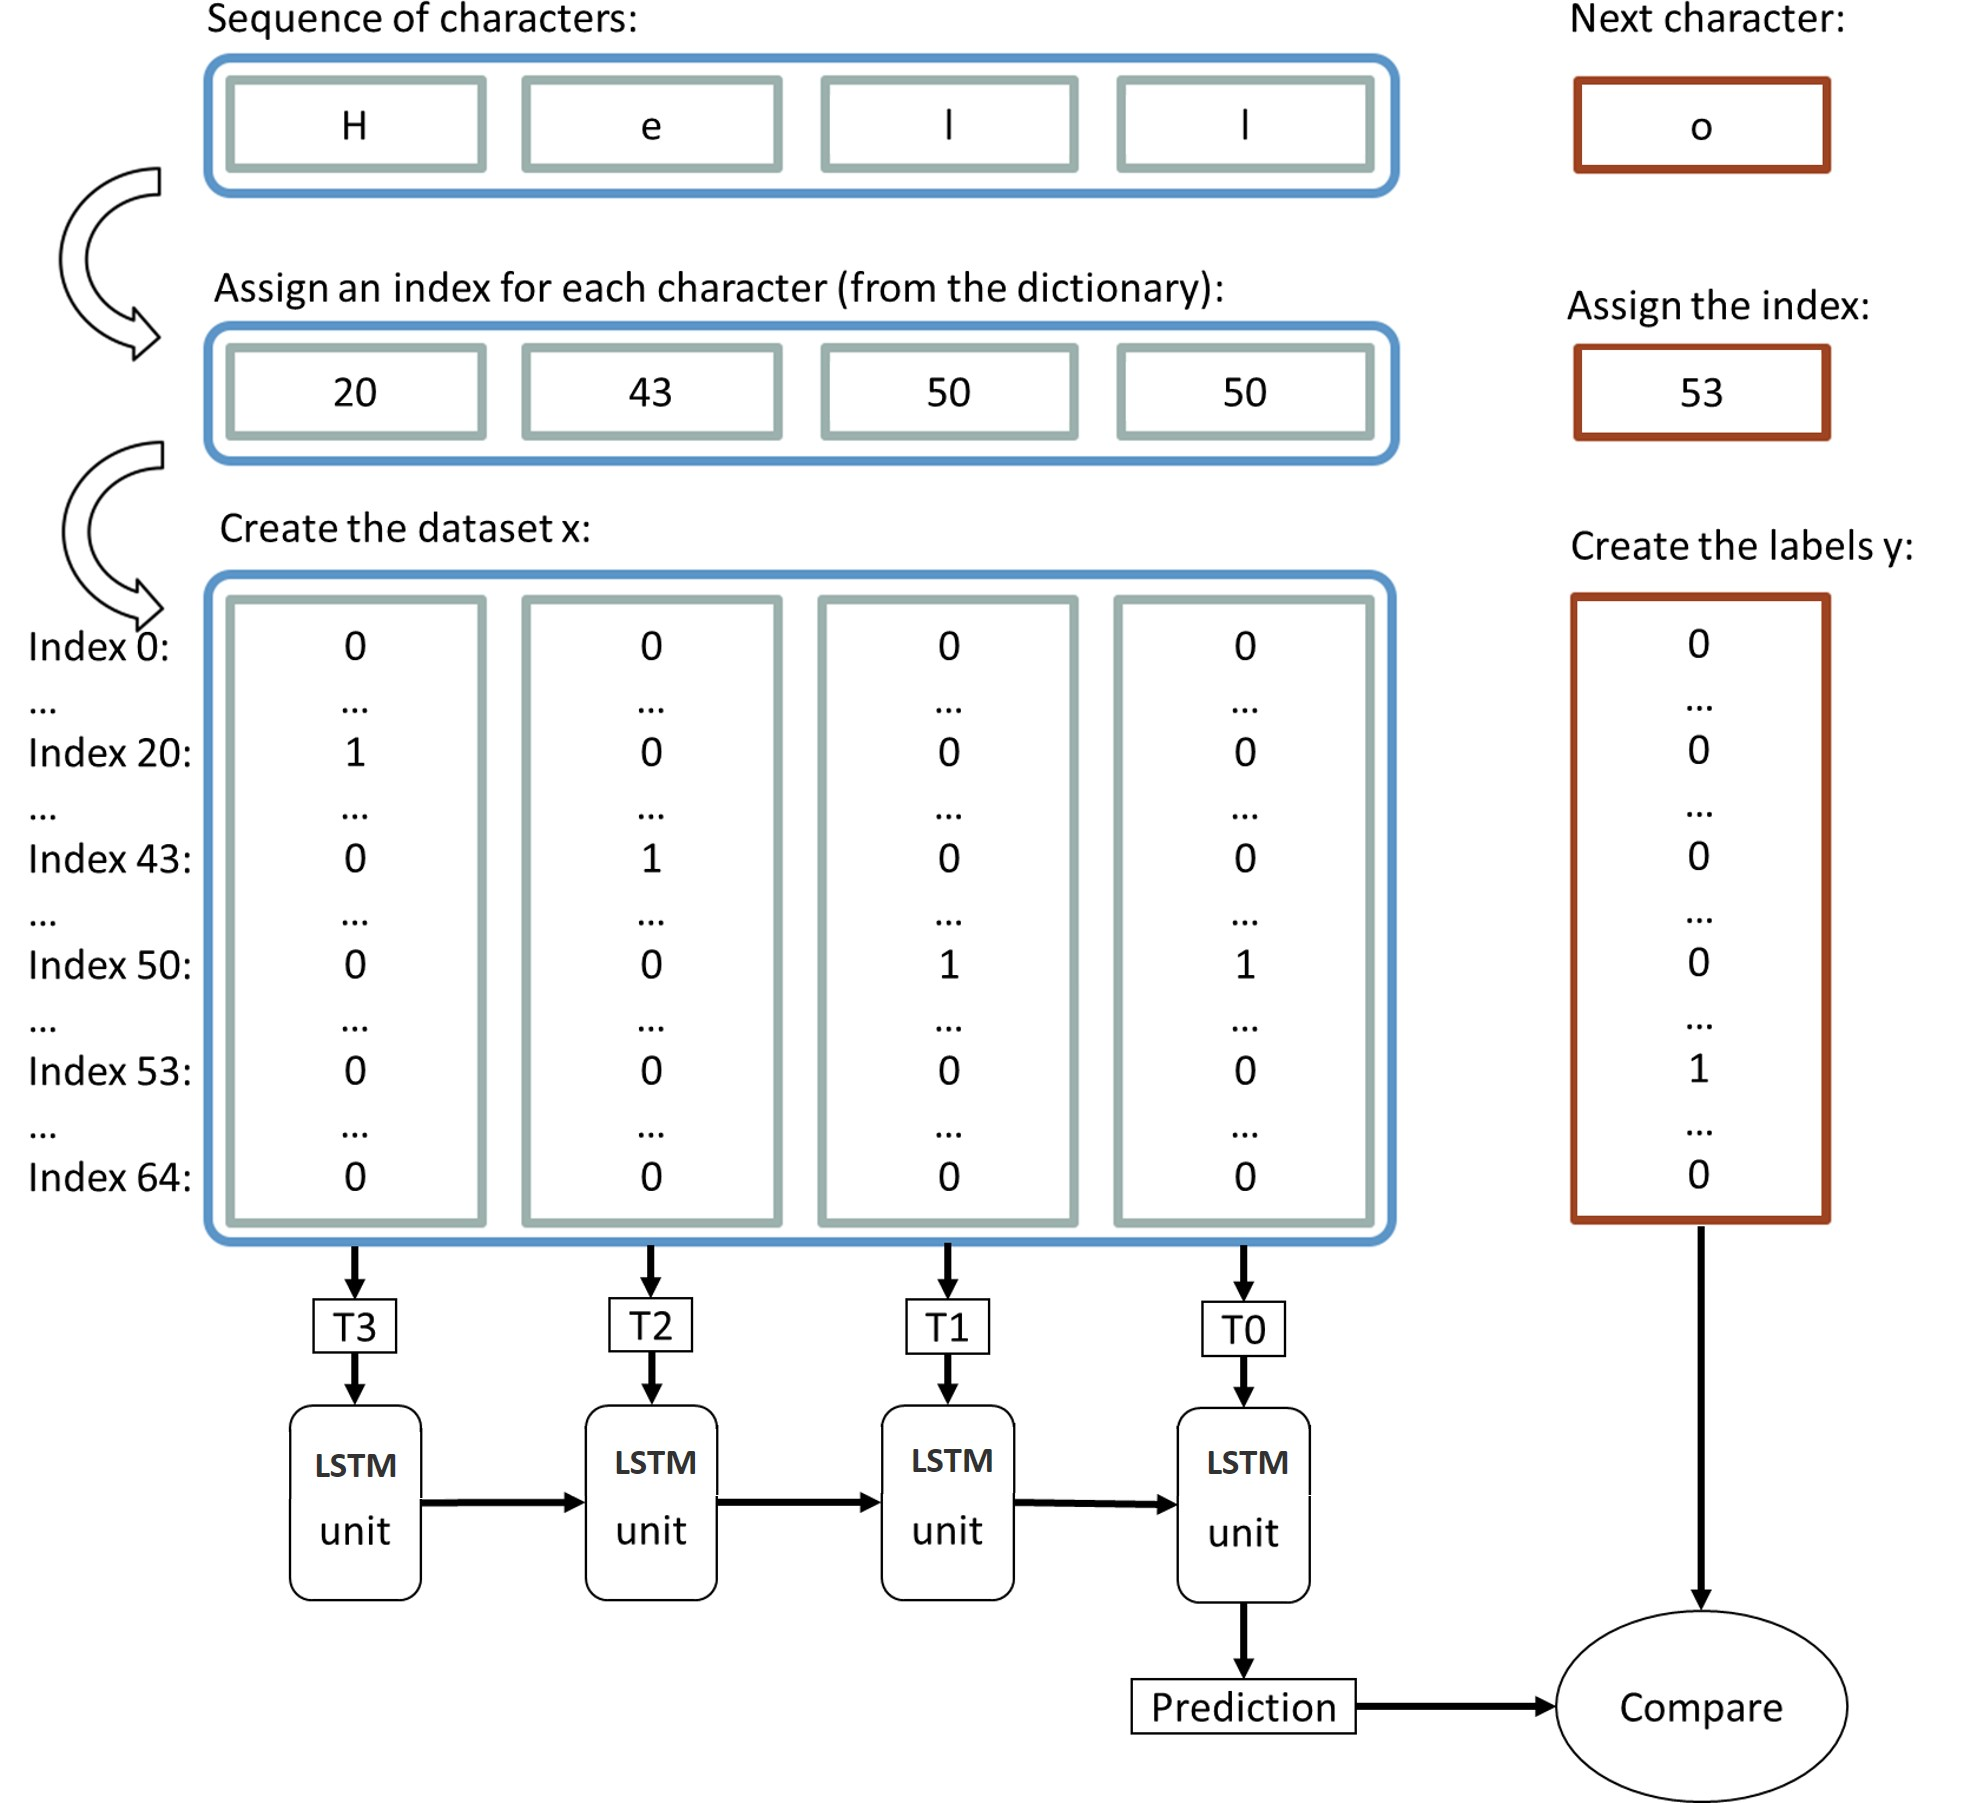

In [4]:
"""
Data Pre-Processing
"""

# produce the sequence of 60 characters shifting forward 3 characters 
maxlen = 60 # extract sequences of length 60
step = 3 # number of character to shift forward 
sentences = []	# holds extracted sequences
nextChars = [] # holds the targets
for c in range(0, len(text)-maxlen, step):
	sentences.append(text[c:c+maxlen])
	nextChars.append(text[c+maxlen])

# before training, convert the strings to a numerical representation using 
# vectorization
chars = sorted(list(set(text))) # find all different characters
vocabLen = len(chars)
# assign a number to identify each character
charIndices = dict((char, chars.index(char)) for char in chars) 
print (f'Index for all characters: {charIndices}')
# produce the dataset
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, charIndices[char]] = 1
  y[i, charIndices[nextChars[i]]] = 1

Index for all characters: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
# x -> each example has 60 time steps and each time step has 65 features (only one is 1 and the rest is 0)
# y -> each example has 65 features (only one is 1 and the rest is 0)
x.shape, y.shape

((371778, 60, 65), (371778, 65))

In [5]:
"""
Building the nn
"""

# specify the model
model = tf.keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, vocabLen)))
model.add(layers.Dense(vocabLen, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam")

# check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               99328     
                                                                 
 dense (Dense)               (None, 65)                8385      
                                                                 
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


In [6]:
"""
Sample the text characters according to the reweighted distribution
"""

# to run on GPU: Runtime->Change runtime type->Hardware Accelerator->GPU
# para correr em GPU: Tempo de execução->Alterar tipo de tempo de execução
# ->Acelerador de hardware->GPU

# estimate the new charcter to include in the sentence
def sample(preds):
  # determine the probability for each character to be the next to be selected
  preds = np.asarray(preds).astype('float64')
  preds = preds / np.sum(preds)
  # sample randomly once from a multinomial distribution characterized by the  
  # probability of each character to be selected next, in oderer to create 
  # diversity in the words and avoid stucking the model in a repetitive
  # sequence with very few characters
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

# train the model
model.fit(x, y, epochs=10, batch_size=128)
# randomly selcted a part of the text to work as test dataset (the seed)
startIndex = random.randint(0, len(text) - maxlen - 1)
seedText = text[startIndex: startIndex + maxlen]
print('Seed to generate text: "' + seedText + '"')
fullSentence = seedText
for i in range(400): # estimate 400 characters after the seed
  # produce the test data (seed)
  sampled = np.zeros((1, maxlen, len(chars)))
  # continue the previous sentence to inclune one new character
  for t, char in enumerate(seedText):
      sampled[0, t, charIndices[char]] = 1.
  # predict one new character
  preds = model.predict(sampled, verbose=0)[0]
  nextIndex = sample(preds)
  nextChar = chars[nextIndex]
  # include the new character in the sentence
  seedText += nextChar
  # keep the same sime of the sentence to form the test dataset
  seedText = seedText[1:]
  fullSentence += nextChar # save the full sentence
print('\nGenerated text: "' + str(fullSentence) + '"')

Epoch 1/10
2905/2905 [==============================] - 26s 7ms/step - loss: 2.4017
Epoch 2/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.9965
Epoch 3/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.8496
Epoch 4/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.7986
Epoch 5/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.7314
Epoch 6/10
2905/2905 [==============================] - 20s 7ms/step - loss: 1.6841
Epoch 7/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.6441
Epoch 8/10
2905/2905 [==============================] - 19s 7ms/step - loss: 1.6099
Epoch 9/10
2905/2905 [==============================] - 20s 7ms/step - loss: 1.5803
Epoch 10/10
2905/2905 [==============================] - 20s 7ms/step - loss: 1.5555
Seed to generate text: "y joints forget
To pay their awful duty to our presence?
If "

Generated text: "y joints forget
To pay their awful duty to our presence

In [7]:
"""
Repeat with famous sentence
"""

# Famous sentence 
StartingText = "To be, or not to be: that is the question. Cruel to be kind."

seedText = StartingText[0 : maxlen]
print('Seed to generate text: "' + seedText + '"')
fullSentence = seedText
for i in range(400): # estimate 400 characters after the seed
  # produce the test data (seed)
  sampled = np.zeros((1, maxlen, len(chars)))
  # continue the previous sentence to inclune one new character
  for t, char in enumerate(seedText):
      sampled[0, t, charIndices[char]] = 1.
  # predict one new character
  preds = model.predict(sampled, verbose=0)[0]
  nextIndex = sample(preds)
  nextChar = chars[nextIndex]
  # include the new character in the sentence
  seedText += nextChar
  # keep the same sime of the sentence to form the test dataset
  seedText = seedText[1:]
  fullSentence += nextChar # save the full sentence
print('\nGenerated text: "' + str(fullSentence) + '"')

Seed to generate text: "To be, or not to be: that is the question. Cruel to be kind."

Generated text: "To be, or not to be: that is the question. Cruel to be kind.

PETRUCHIO:
Sir; he's thou haphha, that dest evil upon him.

KATHARINA:
What's that I'll Gausin own loverd a swall stass.

First Cotichis:
Show's ago you tan thy bringlatch,
I will: you have lest old bey is wither, 'Claw me
Sir, shom, and Im of this place of praves no my Velsing;
But stall not prome the ellick us prove,
But my light, good bidgee strett
With thearnurd all therewings, and gavean
Ho"
